<img src="https://i.imgur.com/6U6q5jQ.png"/>

# Analytics on GeodataFrames

This is time to use  local indicators (social, economic, physical, etc.)  at each spatial location to produce some analytics. Let's follow an approach based on a the amount of variables involved.

Let's create a repo in with GitHub. Put this [file](https://drive.google.com/file/d/1EYacndGCRiF1ZHEnGa-avTXSEtqB2e7p/view?usp=sharing) in the maps folder, and this other [file](https://docs.google.com/spreadsheets/d/1xpsz9n-SBTwgtXsugmabpBJ-tCaEwg9_/edit?usp=sharing&ouid=106935788518947165917&rtpof=true&sd=true) in the data folder. 

Let's read the data in:

In [48]:
# data table
import pandas as pd
import os

datadis=pd.read_excel(os.path.join('data','dataPeru_indicadores.xlsx'),
                     dtype={'Ubigeo': object})
datadis.head()

,Ubigeo,Departamento,Provincia,Distrito,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
0,010202,Amazonas,Bagua,ARAMANGO,10940,809.07,0.361182,37.545885,62.9,9.1
1,010201,Amazonas,Bagua,BAGUA,26091,150.99,0.584063,70.795501,25.4,0.7
2,010203,Amazonas,Bagua,COPALLIN,6319,99.05,0.467245,52.571361,45.4,2.1
3,010204,Amazonas,Bagua,EL PARCO,1492,18.48,0.489049,70.215409,59.9,1.5
4,010205,Amazonas,Bagua,IMAZA,24323,4430.84,0.298089,31.295719,88.4,11.7


In [49]:
# map
import geopandas as gpd

datadismap=gpd.read_file(os.path.join('maps','DistritosMap.zip'))

datadismap.head()

,DEPARTAMEN,PROVINCIA,DISTRITO,INSTITUCIO,geometry
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,IGN,"POLYGON ((-70.17413 -18.12896, -70.17461 -18.1..."
1,TACNA,TACNA,POCOLLAY,IGN,"POLYGON ((-69.93475 -17.92557, -69.90467 -17.9..."
2,TACNA,TACNA,CALANA,IGN,"POLYGON ((-70.11604 -17.91106, -70.11457 -17.9..."
3,TACNA,TACNA,TACNA,IGN,"POLYGON ((-70.31490 -17.94498, -70.30682 -17.9..."
4,TACNA,TACNA,SAMA,IGN,"POLYGON ((-70.42497 -17.88934, -70.48022 -17.9..."


## Preprocessing

After observing both tables, it would be better if the columns with names have the same capitalization, and no extra blank spaces:

In [50]:
capitalizeColumns=lambda x: x.str.upper().str.strip()
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].apply(capitalizeColumns)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].apply(capitalizeColumns)

The names from non-english speaking countries may come with some symbols that may cause trouble (', ~). Let's get rid of those:

In [51]:
import unidecode


byePunctuation=lambda x: unidecode.unidecode(x)
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].map(byePunctuation)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].map(byePunctuation)

Let me see how many district we have:

In [52]:
len(datadis.Distrito),len(datadismap.DISTRITO)

(1874, 1874)

Are the name of the districts unique?

In [53]:
datadis.Distrito.duplicated().sum(),datadismap.DISTRITO.duplicated().sum()

(154, 152)

The presence of duplicates, forces we create  a column of unique values:

In [54]:
# concatenating
datadis['provDist']=["+".join(pd) for pd in zip (datadis.Provincia,datadis.Distrito)]
datadismap['provDist']=["+".join(pd) for pd in zip (datadismap.PROVINCIA,datadismap.DISTRITO)]

In [55]:
# the new column looks like this:
datadis['provDist'].head()

0    BAGUA+ARAMANGO
1       BAGUA+BAGUA
2    BAGUA+COPALLIN
3    BAGUA+EL PARCO
4       BAGUA+IMAZA
Name: provDist, dtype: object

It would be good making sure no *ghost* appears between words:

In [56]:
# replacing dashes and multiple spaces by a simple space
datadis.provDist=datadis.provDist.str.replace("\-|\_|\s+"," ",regex=True)
datadismap.provDist=datadismap.provDist.str.replace("\-|\_|\s+"," ",regex=True)

## Merging

We need to merge both tables now. That can happen effectively if both tables have a **key** column: a column (or collection of them) whose values in one table are the same in the other one.

The match need not be exact, but only common values in the *key* are merged.

Let's find out what is NOT matched in each table:

In [57]:
nomatch_df=set(datadis.provDist)- set(datadismap.provDist)
nomatch_gdf=set(datadismap.provDist)-set(datadis.provDist) 

This is what could not be matched:

In [58]:
len(nomatch_df), len(nomatch_gdf)

(8, 8)

The datadis df does not have 26 values in its provDist column that match in the provDist column in datadismap gdf, the same count happens the way around. 

You can try renaming here row by row (or in the original file), but the right way to go is using **fuzzy merging**, please install _the fuzz_ and _python-Levenshtein_:

In [59]:
# pick the closest match from nomatch_gdf for a value in nomatch_df
from thefuzz import process
[(dis,process.extractOne(dis,nomatch_gdf)) for dis in sorted(nomatch_df)]

[('ANGARAES+HUAYLLAY GRANDE', ('ANGARAES+HUALLAY GRANDE', 98)),
 ('AYMARAES+CARAYBAMBA', ('AYMARAES+CARAIBAMBA', 95)),
 ('AYMARAES+HUAYLLO', ('AYMARAES+IHUAYLLO', 97)),
 ('HUARAZ+PAMPAS', ('HUARAZ+PAMPAS GRANDE', 90)),
 ('LEONCIO PRADO+DANIEL ALOMIAS ROBLES',
  ('LEONCIO PRADO+DANIEL ALOMIA ROBLES', 99)),
 ('LIMA+PUEBLO LIBRE', ('LIMA+MAGDALENA VIEJA', 49)),
 ('PIURA+26 DE OCTUBRE', ('PIURA+VEINTISEIS DE OCTUBRE', 86)),
 ('SAN MARTIN+PAPAPLAYA', ('SAN MARTIN+PAPA PLAYA', 98))]

If you are comfortable, you prepare a _dictionary_ of changes:

In [60]:
# is this OK?
{dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

{'ANGARAES+HUAYLLAY GRANDE': 'ANGARAES+HUALLAY GRANDE',
 'AYMARAES+CARAYBAMBA': 'AYMARAES+CARAIBAMBA',
 'AYMARAES+HUAYLLO': 'AYMARAES+IHUAYLLO',
 'HUARAZ+PAMPAS': 'HUARAZ+PAMPAS GRANDE',
 'LEONCIO PRADO+DANIEL ALOMIAS ROBLES': 'LEONCIO PRADO+DANIEL ALOMIA ROBLES',
 'LIMA+PUEBLO LIBRE': 'LIMA+MAGDALENA VIEJA',
 'PIURA+26 DE OCTUBRE': 'PIURA+VEINTISEIS DE OCTUBRE',
 'SAN MARTIN+PAPAPLAYA': 'SAN MARTIN+PAPA PLAYA'}

In [61]:
# then:
changesDis_df={dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

Now, make the replacements:

In [62]:
datadis.provDist.replace(changesDis_df,inplace=True)

Now the merge can happen:

In [63]:
datadismap=datadismap.merge(datadis, on='provDist')

In [64]:
# check
datadismap.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   DEPARTAMEN                1874 non-null   object  
 1   PROVINCIA                 1874 non-null   object  
 2   DISTRITO                  1874 non-null   object  
 3   INSTITUCIO                1874 non-null   object  
 4   geometry                  1874 non-null   geometry
 5   provDist                  1874 non-null   object  
 6   Ubigeo                    1874 non-null   object  
 7   Departamento              1874 non-null   object  
 8   Provincia                 1874 non-null   object  
 9   Distrito                  1874 non-null   object  
 10  Poblacion                 1874 non-null   int64   
 11  Superficie                1874 non-null   float64 
 12  IDH2019                   1874 non-null   float64 
 13  Educ_sec_comp2019_pct     1874 non-null 

We can get rid of some columns:

In [65]:
bye=['Departamento', 'Provincia', 'Distrito','INSTITUCIO','provDist']
datadismap.drop(columns=bye,inplace=True)

# keeping
datadismap.head()

,DEPARTAMEN,PROVINCIA,DISTRITO,geometry,Ubigeo,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,"POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...",230110,123662,187.74,0.578968,71.178389,15.8,0.8
1,TACNA,TACNA,POCOLLAY,"POLYGON ((-69.93475 -17.92557, -69.90467 -17.9...",230108,22319,265.65,0.645954,75.825743,16.1,0.9
2,TACNA,TACNA,CALANA,"POLYGON ((-70.11604 -17.91106, -70.11457 -17.9...",230103,3338,108.38,0.564102,77.829717,15.9,3.3
3,TACNA,TACNA,TACNA,"POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...",230101,80845,1877.78,0.696613,75.491958,7.4,0.6
4,TACNA,TACNA,SAMA,"POLYGON ((-70.42497 -17.88934, -70.48022 -17.9...",230109,2679,1115.98,0.552622,70.500250,52.4,10.8


We can save this gdf:

In [66]:
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

## Exploring one variable

This time, we explore statistically one variable:

In [71]:
# statistics
datadismap.select_dtypes(include=np.number).describe()

,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
count,1.874000e+03,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000
mean,1.716231e+04,689.613751,0.409405,55.769523,38.593330,17.068783
std,5.483361e+04,1922.273572,0.140059,15.728123,18.297153,16.354910
min,1.740000e+02,1.990000,0.091195,11.974433,1.100000,0.000000
25%,1.907250e+03,92.910000,0.304729,44.466678,24.900000,4.925000
50%,4.538500e+03,208.010000,0.386020,57.164771,35.300000,12.050000
75%,1.136975e+04,500.092500,0.507002,68.202230,49.275000,24.100000
max,1.156300e+06,24049.950000,0.845217,91.744878,99.400000,96.500000


This plot tells you the distribution of the values, but not the presence of outliers, which you are revealed in a boxplot:

<Axes: >

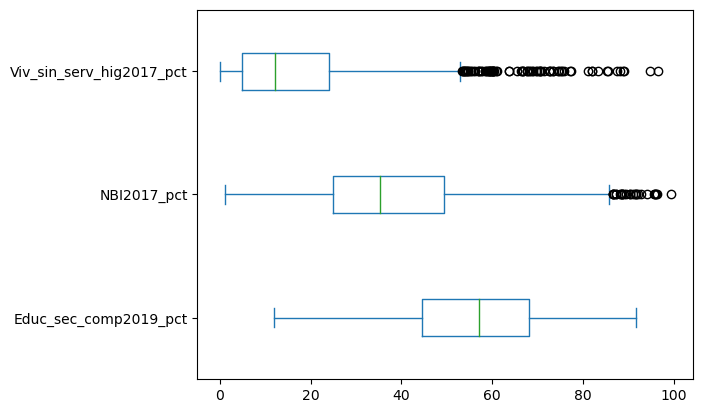

In [84]:
datadismap.select_dtypes(include=np.number).iloc[:,3:].plot(kind='box',vert=False)

Notice the histogram divides the data in intervals which are the base of the bars. Seaborn uses the [Freedman-Diaconis](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule) formula to compute the bins.

Let's see other possibilities, but please install [**numba**](https://numba.readthedocs.io/en/stable/user/installing.html) before runing the next code; also make sure you have **pysal**, **mapclassify** and **numpy** installed: 

Let's see the **HeadTailBreaks** results:

In [ ]:
# a frequency table by default
ht

In [ ]:
# group label
ht.yb

In [ ]:
# labels and counts
np.unique(ht.yb,return_counts=True)
          

In [ ]:
# ht.yb into a pandas Series

pd.Series(ht.yb).value_counts()

In [ ]:
# these are the cuts, but it is not including the min value
ht.bins

Based on the previous information, let me prepare a histogram:

In [ ]:
# completing the bins
HT_bins=list(ht.bins)
HT_bins.insert(0,datadismap.IDH2019.min())

In [ ]:
sea.displot(datadismap.IDH2019, bins=HT_bins,color='yellow')

How can we select the right classification. Let me use the the Absolute deviation around class median (ADCM) to make the comparisson:

In [ ]:

class5 = q5, ei5,msd, ht, mb5, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']
ax = sea.barplot(
    y='Classifier', x='ADCM', data=adcms, palette='Pastel1'
)

Let's keep the three schemes with the lowest  ADCM:

In [ ]:
datadismap['QU'] = q5.yb 
datadismap['FJ'] = fj5.yb
datadismap['JC'] = jc5.yb

In [ ]:
# how many cases per scheme:

class5new = q5,fj5, jc5
pd.DataFrame(
    {c.name: c.counts for c in class5new},
    index=['Class-{}'.format(i) for i in range(5)]
)

Let me plot one of them:

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(9, 9))
datadismap.plot(column='QU', 
        cmap='viridis', 
        categorical=True,
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

Notice the **geopandas.plot()** can also use those schemes:

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
datadismap.plot(column='IDH2019', 
        cmap='viridis',       
        scheme='Quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

Let's save what we have:

In [ ]:
# update
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

### Exercise 2

<div class="alert-success">
    
1. Choose a numeric variable from your merged data.
2. Decide which are the three best classification schemes for that variable.
3. Make a map for each scheme selected.    
</div>

# Exploring several variables

We can turn our attention to several variables now:

In [ ]:
selected_variables = ['Educ_sec_comp2019_pct',
                     'NBI2017_pct', 
                     'Viv_sin_serv_hig2017_pct']
datadismap[selected_variables].describe()

Visualization in a key procedure to detect the need for further data transformation:

In [ ]:
sea.boxplot(datadismap[selected_variables])

In [ ]:
datadismap[selected_variables].hist();

Both univariate plots do not allow to see the relationships. Let's try a scatterplot:

In [ ]:
sea.pairplot(
    datadismap[selected_variables], kind="reg", diag_kind="kde"
)

We finally realize that **Educ_sec_comp2019_pct** has a negative correlation with the others (as expected). Let me reverse the variable:

In [ ]:
reverse=lambda x:abs(x-x.max())+x.min()

datadismap['Educ_sec_NO_comp2019_pct']=reverse(datadismap['Educ_sec_comp2019_pct'])
datadismap['Educ_sec_NO_comp2019_pct'].hist()

Now all our correlations will be positive:

In [ ]:
selected_variables_new = ['Educ_sec_NO_comp2019_pct',
                     'NBI2017_pct', 
                     'Viv_sin_serv_hig2017_pct']
sea.pairplot(
    datadismap[selected_variables_new], kind="reg", diag_kind="kde"
)

Keep in mind that the boxplot showed outliers. Let me try to re scale the data to smooth the distribution a little:

In [ ]:
columnsToScale=selected_variables_new


from sklearn.preprocessing import robust_scale as rs
from sklearn.preprocessing import power_transform as pt
from sklearn.preprocessing import quantile_transform as qt

rs_result=rs(datadismap[columnsToScale])
pt_result=pt(datadismap[columnsToScale])
qt_result=qt(datadismap[columnsToScale])

Let's see the results:

In [ ]:
pd.DataFrame(rs_result).boxplot(vert=False)

In [ ]:
pd.DataFrame(pt_result).boxplot(vert=False)

In [ ]:
pd.DataFrame(qt_result).boxplot(vert=False)

I will keep the **qt_result**, so let me add some columns to the gdf:

In [ ]:
# new names
selected_variables_new_t=[s+'_t' for s in selected_variables_new ]

# add colunms
datadismap[selected_variables_new_t]=qt_result

Let's plot the data we have used (I will the quantiles scheme **without** pre evaluation):

In [ ]:
f, axs = plt.subplots( ncols=3, nrows=3,figsize=(10, 10))
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(selected_variables_new_t + selected_variables_new + selected_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    datadismap.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

In [ ]:
# update
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

### Exercise 3

<div class="alert-success">
    
1. Select three numeric variables.
    
2. Explore each one as above:
    * If needed reverse the variables (so that correlations are positive)
    * If needed re scale the variables (so that outliers are smoothed)
    * Evalue the  classification schemes for each variable.

4. Prepare a map for each variable, using the best classification scheme for each variable.


    
</div>

## Clustering

We used clustering to organize the data into homogeneus groups. Let me use a **dendogram** to explore the possible clusters:

In [ ]:
from scipy.cluster import hierarchy as hc


Z = hc.linkage(qt_result, 'ward')
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('cases')
plt.ylabel('distance')
hc.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=1,  # font size for the x axis labels
)
plt.show()

I have used all the variables in the dendogram, so I can decide how many groups could be created using that data:

In [ ]:
from sklearn.cluster import AgglomerativeClustering as agnes
# Set seed for reproducibility
np.random.seed(12345)
# Initialize the algorithm, requesting 3 clusters
model = agnes(linkage="ward", n_clusters=3).fit(datadismap[selected_variables_new_t])
# Assign labels to main data table
datadismap["hc_3"] = model.labels_

I reduce all the information from the three variables into a cluster variable:

In [ ]:
datadismap["hc_3"].value_counts()

Let's use the mean of each variable to understand the clusters:

In [ ]:
datadismap.groupby("hc_3")[selected_variables_new].mean()

I could profile the clusters better if I prepare a plot with all the variables. Let me create a new data frame in long shape:

In [ ]:
# Index db on cluster ID
datadismap_long = datadismap.set_index("hc_3").copy()
# Keep only variables used for clustering
datadismap_long = datadismap_long[selected_variables_new]
# Stack column names into a column, obtaining
# a "long" version of the dataset
datadismap_long = datadismap_long.stack()
# Take indices into proper columns
datadismap_long = datadismap_long.reset_index()
# Rename column names
datadismap_long = datadismap_long.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
datadismap_long.head()

Nos the profiling:

In [ ]:
# Setup the facets
facets = sea.FacetGrid(
    data=datadismap_long,
    col="hc_3",
    hue="Attribute",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot as a `sns.kdeplot`
facets.map(sea.kdeplot, "Values", fill=True).add_legend()

Finally, just color the map:

In [ ]:
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
datadismap.plot(
    column="hc_3", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

### Exercise 4

<div class="alert-success">
    
1. Keep the previous three variables, after you pre processed them.
    
2. Prepare a dendogram, and decide which is better: 3 or 5 clusters.
    
3. Cluster the data into the amount of clusters selected.

4. Prepare a visualization to profile each cluster.

5. Plot the cluster map.


    
</div>

## Spatial Correlation

### Neighboorhood

We can compute the neighborhood in a map using different algorithms:

In [ ]:
from libpysal.weights import Queen, Rook, KNN

# rook
w_rook = Rook.from_dataframe(datadismap) 

In [ ]:
# rook
w_queen = Queen.from_dataframe(datadismap)

In [ ]:
# k nearest neighbors
w_knn = KNN.from_dataframe(datadismap, k=4)

Let's understand the differences:

In [ ]:
# first one
datadismap.head(1)

In [ ]:
# amount neighbors of that district
w_rook.neighbors[0] 

In [ ]:
# see
base=datadismap[datadismap.PROVINCIA=="TACNA"].plot()
datadismap.iloc[w_rook.neighbors[0] ,].plot(ax=base,facecolor="yellow")
datadismap.head(1).plot(ax=base,facecolor="red")

Let's do the same:

In [ ]:
w_queen.neighbors[0]

In [ ]:
base=datadismap[datadismap.PROVINCIA=="TACNA"].plot()
datadismap.iloc[w_queen.neighbors[0] ,].plot(ax=base,facecolor="yellow")
datadismap.head(1).plot(ax=base,facecolor="red")

In [ ]:
w_knn.neighbors[0]

In [ ]:

base=datadismap[datadismap.PROVINCIA=="TACNA"].plot()
datadismap.iloc[w_knn.neighbors[0],].plot(ax=base,facecolor="yellow")
datadismap.head(1).plot(ax=base,facecolor="red")

Let me pay attention to the knn results:

In [ ]:
# all the neighbors by row
w_knn.neighbors

In [ ]:
# the matrix of neighboorhood:

pd.DataFrame(*w_knn.full()).astype(int) # 1 means both are neighbors

In [ ]:
# count of zeros
w_knn.nonzero

In [ ]:
# pct of neighboorhood (density)
w_knn.pct_nonzero

In [ ]:
# a district with NO neighbor?
w_knn.islands

### Exercise 5

<div class="alert-success">
    
1. Compute the three neighboohoods shown above for you data.
    
2. Select one polygon, and plot it with its neighbors as above.
    
</div>

## Spatial correlation

We need the neighboorhood matrix (the weight matrix) to compute spatial correlation: if the variable value is correlated with the values of its neighbors - which proves a spatial effect.

In [ ]:
# needed for spatial correlation
w_knn.transform = 'R'

Spatial correlation is measured by the Moran's I statistic:

In [ ]:
from esda.moran import Moran

moranIDH = Moran(datadismap['IDH2019'], w_knn)
moranIDH.I,moranIDH.p_sim

A significant Moran's I suggest spatial correlation. Let's see the spatial scatter plot

In [ ]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(moranIDH, aspect_equal=True)
ax.set_xlabel('IDH_std')
ax.set_ylabel('SpatialLag_IDH_std')
plt.show()

### Exercise 6

<div class="alert-success">
    
1. Compute the Moran's coefficient for **all** your numeric variables.
    
2. Make a scatter plot for each variable.
    
</div>

### Local Spatial Correlation

We can compute a LISA (local Moran) for each case. That will help us find spatial clusters (spots) and spatial outliers:

* A **hotSpot** is a polygon whose value in the variable is high AND is surrounded with polygons with also high values.

* A **coldSpot** is a polygon whose value in the variable is low AND is surrounded with polygons with also low values.

* A **coldOutlier** is a polygon whose value in the variable is low BUT is surrounded with polygons with  high values.

* A **hotOutlier** is a polygon whose value in the variable is high BUT is surrounded with polygons with  low values.

It is also possible that no significant correlation is detected. Let's see those values:

In [ ]:
# The scatterplot with local info
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisaIDH = Moran_Local(y=datadismap['IDH2019'], w=w_knn,seed=2022)
fig, ax = moran_scatterplot(lisaIDH,p=0.05)
ax.set_xlabel('IDH_std')
ax.set_ylabel('SpatialLag_IDH_std')
plt.show()

In [ ]:
# the map with the spots and outliers

from splot.esda import lisa_cluster
f, ax = plt.subplots(1, figsize=(12, 12))
plt.title('Spots and Outliers')
fig = lisa_cluster(lisaIDH, 
                   datadismap,ax=ax,
                   legend_kwds={'loc': 'center left', 
                                'bbox_to_anchor': (0.7, 0.6)})
plt.show()

Let me add that data to my gdf:

In [ ]:
# quadrant
lisaIDH.q

In [ ]:
# significance
lisaIDH.p_sim

In [ ]:
# quadrant: 1 HH,  2 LH,  3 LL,  4 HL
pd.Series(lisaIDH.q).value_counts()

The info in **lisaIDH.q** can not be used right away, we need to add if the local spatial correlation is significant:

In [ ]:
datadismap['IDH_quadrant']=[l if p <0.05 else 0 for l,p in zip(lisaIDH.q,lisaIDH.p_sim)  ]
datadismap['IDH_quadrant'].value_counts()

Now, we recode:

In [ ]:
labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']

datadismap['IDH_quadrant_names']=[labels[i] for i in datadismap['IDH_quadrant']]

datadismap['IDH_quadrant_names'].value_counts()
                                  

Let's replot:

In [ ]:
from matplotlib import colors
myColMap = colors.ListedColormap([ 'ghostwhite', 'red', 'green', 'black','orange'])



# Set up figure and ax
f, ax = plt.subplots(1, figsize=(12,12))
# Plot unique values choropleth including
# a legend and with no boundary lines

plt.title('Spots and Outliers')

datadismap.plot(column='IDH_quadrant_names', 
                categorical=True,
                cmap=myColMap,
                linewidth=0.1, 
                edgecolor='white',
                legend=True,
                legend_kwds={'loc': 'center left', 
                             'bbox_to_anchor': (0.7, 0.6)},
                ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [ ]:
# final update
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

### Exercise 7

<div class="alert-success">
    
1. Compute the Local Moran for the variables in your data that have significant spatial correlation.
    
2. Create a new column for each of those variables, with a label ('0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier').

3. Prepare a map for each of the variables analyzed, showing the spots and outliers.
    
</div>